## 10.5.3 例：英国における自動車運転者死傷者数
- モデルが複雑(状態の数が多い、規定階層が深い、非線形性が強い)になってくると、改善の有効性が増す
- ローカルレベル+周期モデル(時間領域アプローチ)で分析を行うことにする
    - 線形・ガウス型状態空間モデルなので、カルマンフィルタを部品として利用することで推定の安全性を改善できる

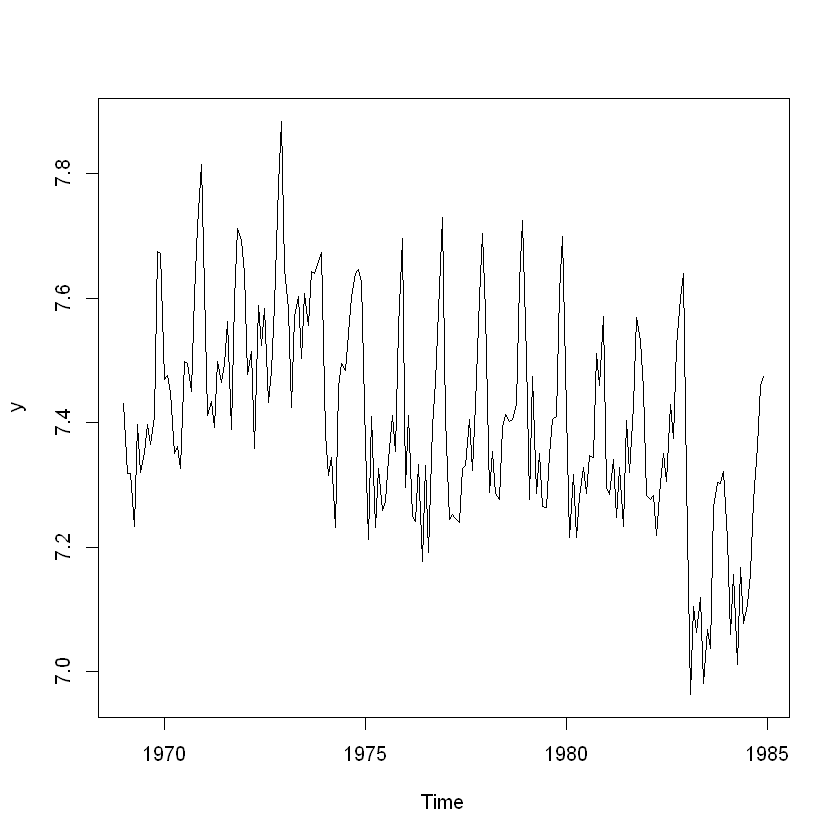

In [1]:
#【英国における自動車運転者死傷者数：カルマン平滑化】

# 前処理
set.seed(123)
library(dlm)

# データを対数変換、時系列長の設定
y <- log(UKDriverDeaths)
t_max <- length(y)

# 横軸時間のプロット
plot(y)

In [2]:
# モデルのテンプレート
mod <- dlmModPoly(order = 1) + dlmModSeas(frequency = 12)

# モデルを定義・構築するユーザ定義関数
build_dlm_UKD <- function(par) {
  mod$W[1, 1] <- exp(par[1])
  mod$W[2, 2] <- exp(par[2])
  mod$V[1, 1] <- exp(par[3])

  return(mod)
}

# パラメータの最尤推定
fit_dlm_UKD <- dlmMLE(y = y, parm = rep(0, times = 3), build = build_dlm_UKD)

Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"
Warning message in dlmLL(y = y, mod = mod, debug = debug):
"a numerically singular 'V' has been slightly perturbed to make it nonsingular"


- 状態の事前分布の平均ベクトルは0、共分散行列は$10^7$I (デフォルト)
- パラメータを最尤推定する際に警告
    - dlmによるもので、観測雑音が0に近づいた場合、非常に小さな値($10^{-6}$)を付加したことをしめす
    - 今回は結果に大きな影響を与えないため無視

In [3]:
# モデルの設定と結果の確認
mod <- build_dlm_UKD(fit_dlm_UKD$par)
cat(diag(mod$W)[1:2], mod$V, "\n")

0.000945628 1.894144e-10 0.003513922 


- レベル成分の状態雑音の分散、周期成分の状態雑音の分散、観測雑音の分散
- 実データが対象であるためこの値が正解というわけではないが、目安にはなる

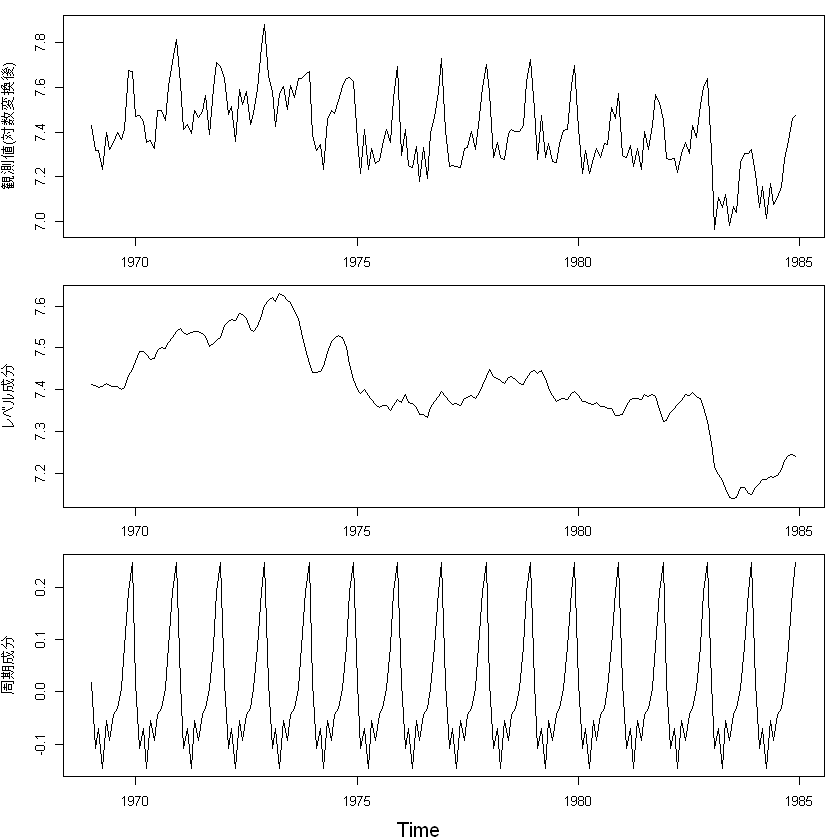

In [4]:
# 平滑化処理
dlmSmoothed_obj <- dlmSmooth(y = y, mod = mod)

# 平滑化分布の平均
   mu <- dropFirst(dlmSmoothed_obj$s[, 1])
gamma <- dropFirst(dlmSmoothed_obj$s[, 2])

# 結果のプロット
oldpar <- par(no.readonly = TRUE)
par(mfrow = c(3, 1)); par(oma = c(2, 0, 0, 0)); par(mar = c(2, 4, 1, 1))
ts.plot(    y, ylab = "観測値(対数変換後)")
ts.plot(   mu, ylab = "レベル成分")
ts.plot(gamma, ylab = "周期成分")
mtext(text = "Time", side = 1, line = 1, outer = TRUE)
par(oldpar)

- 上から、観測値、レベル成分(平滑化分布の平均)、周期成分(平滑化分布の平均)

### MCMCを用いた方法
- 状態とパラメータを合わせてMCMCでサンプリングする

```
// model10-4.stan
// モデル：規定【ローカルレベルモデル+周期モデル(時間領域アプローチ）】

data{
  int<lower=1>    t_max;            // 時系列長
  vector[t_max]       y;            // 観測値

  vector[12]         m0;            // 事前分布の平均ベクトル
  cov_matrix[12]     C0;            // 事前分布の共分散行列
}

parameters{
  real              x0_mu;          // 状態（レベル成分）[0]
  vector[11]        x0_gamma;       // 状態（　周期成分）[0]
  vector[t_max]      x_mu;          // 状態（レベル成分）[1:t_max]
  vector[t_max]      x_gamma;       // 状態（　周期成分）[1:t_max]

  real<lower=0>      W_mu;          // 状態雑音（レベル成分）の分散
  real<lower=0>      W_gamma;       // 状態雑音（　周期成分）の分散
  cov_matrix[1]      V;             // 観測雑音の共分散行列
}

model{
  // 尤度の部分
  /* 観測方程式 */
  for (t in 1:t_max){
    y[t] ~ normal(x_mu[t] + x_gamma[t], sqrt(V[1, 1]));
  }

  // 事前分布の部分
  /* 状態（レベル成分）の事前分布 */
  x0_mu ~ normal(m0[1], sqrt(C0[1, 1]));

  /* 状態方程式（レベル成分） */
    x_mu[1] ~ normal(x0_mu     , sqrt(W_mu));
  for(t in 2:t_max){
    x_mu[t] ~ normal( x_mu[t-1], sqrt(W_mu));
  }

  /* 状態（周期成分）の事前分布 */
  for (p in 1:11){
    x0_gamma[p] ~ normal(m0[p+1], sqrt(C0[(p+1), (p+1)]));
  }

  /* 状態方程式（周期成分） */
    x_gamma[1] ~ normal(-sum(x0_gamma[1:11])                           ,
                                                                     sqrt(W_gamma));
  for(t in 2:11){
    x_gamma[t] ~ normal(-sum(x0_gamma[t:11])-sum(x_gamma[     1:(t-1)]),
                                                                     sqrt(W_gamma));
  }
  for(t in 12:t_max){
    x_gamma[t] ~ normal(                    -sum(x_gamma[(t-11):(t-1)]),
                                                                     sqrt(W_gamma));
  }

  /* W, Vの事前分布：無情報事前分布（省略時のデフォルト設定を活用） */
}

```

In [5]:
#【英国における自動車運転者死傷者数：MCMCで状態もサンプリングする】

# 前処理
set.seed(123)
library(rstan)

# Stanの事前設定：コードのHDD保存、並列演算、グラフの縦横比
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
theme_set(theme_get() + theme(aspect.ratio = 3/4))

 要求されたパッケージ StanHeaders をロード中です 

 要求されたパッケージ ggplot2 をロード中です 


 次のパッケージを付け加えます: 'ggplot2' 


 以下のオブジェクトは 'package:dlm' からマスクされています: 

     %+% 


rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Do not specify '-march=native' in 'LOCAL_CPPFLAGS' or a Makevars file



In [6]:
# モデル：生成・コンパイル
stan_mod_out <- stan_model(file = "model10-4.stan")

In [7]:
fit_scan <- sampling(object = stan_mod_out, 
                    data = list(n = t_max, y = y, m0 = mod$m0, C0 = mod$C0),
                    pars = c("W_mu", "W_gamma", "V"),
                    seed = 123)

Warning message:
"There were 20 divergent transitions after warmup. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"There were 949 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded"
Warning message:
"There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low"
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Warning message:
"The largest R-hat is 1.21, indicating chains have not mixed.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#r-hat"
Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://m

In [8]:
fit_scan

Inference for Stan model: model10-4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff Rhat
W_mu       0.0    0.00  0.0    0.00    0.00    0.00    0.00    0.00   386 1.02
W_gamma    0.0    0.00  0.0    0.00    0.00    0.00    0.00    0.00    40 1.13
V[1,1]     0.0    0.00  0.0    0.00    0.00    0.00    0.00    0.00   883 1.00
lp__    1851.6   23.73 99.7 1697.19 1782.52 1835.05 1899.82 2075.59    18 1.26

Samples were drawn using NUTS(diag_e) at Fri Aug 06 15:01:03 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

- sampling()の実行時に収束の悪化が検知され、警告が出ている
- W_gamma(周期成分の状態雑音)のn_eff, Rhatの値が悪い

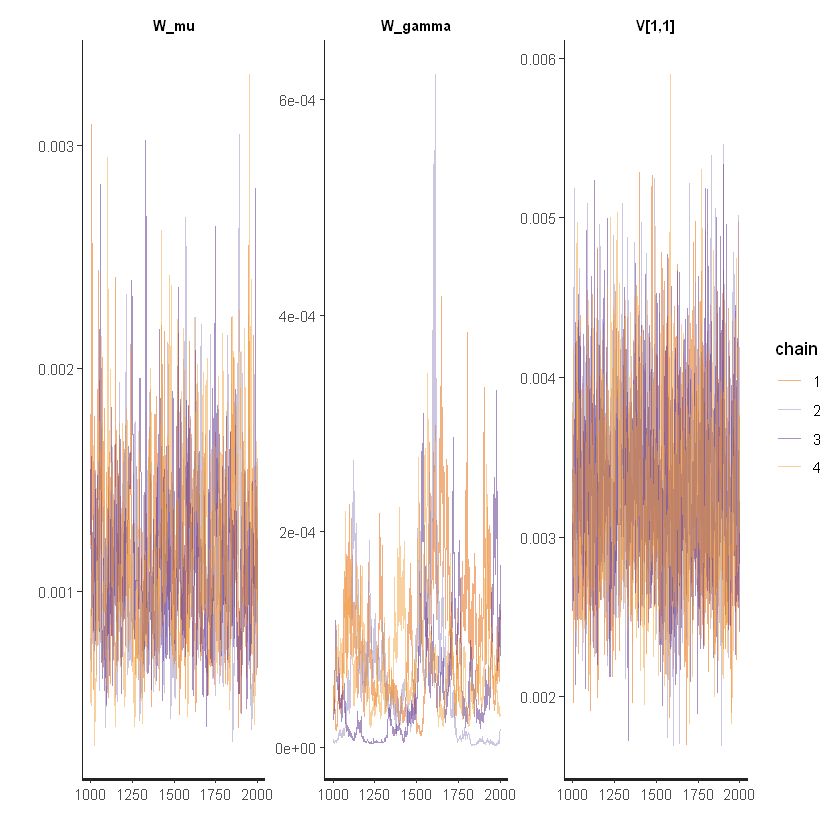

In [9]:
traceplot(fit_scan, pars = c("W_mu", "W_gamma", "V"), alpha = 0.5)

- 周期成分(真ん中)の推定結果の混ざり具合が悪い

### MCMCを用いる
- 次に、パラメータのみをMCMCでサンプリングし、そのあとFFBSで状態のサンプルを再生する

```
// model10-5.stan
// モデル：規定【ローカルレベルモデル+周期モデル(時間領域アプローチ）、カルマンフィルタを活用】

data{
  int<lower=1>    t_max;           // 時系列長
  matrix[1, t_max]    y;           // 観測値

  matrix[12, 12]      G;           // 状態遷移行列
  matrix[12,  1]      F;           // 観測行列
  vector[12]         m0;           // 事前分布の平均ベクトル
  cov_matrix[12]     C0;           // 事前分布の共分散行列
}

parameters{
  real<lower=0>       W_mu;        // 状態雑音（レベル成分）の分散
  real<lower=0>       W_gamma;     // 状態雑音（　周期成分）の分散
  cov_matrix[1]       V;           // 観測雑音の共分散行列
}

transformed parameters{
    matrix[12, 12]    W;           // 状態雑音の共分散行列

    for (k in 1:12){               // Stanのmatrixでは列優先のアクセスが高速
      for (j in 1:12){
             if (j == 1 && k == 1){ W[j, k] = W_mu;     }
        else if (j == 2 && k == 2){ W[j, k] = W_gamma;  }
        else{                       W[j, k] = 0;        }
      }
    }
}

model{
  // 尤度の部分
  /* 線形・ガウス型状態空間モデルの尤度を求める関数 */
  y ~ gaussian_dlm_obs(F, G, V, W, m0, C0);

  // 事前分布の部分
  /* W, Vの事前分布：無情報事前分布（省略時のデフォルト設定を活用） */
}

```

- transformed parameters ブロックでは、dataブロックで宣言された定数やparametersブロックで宣言されたパラメータを利用して、計算に便利な別のパラメータを定義することが可能
- 今回ここでは、状態雑音の共分散行列を組み立てている

In [10]:
#【英国における自動車運転者死傷者数：MCMCで状態はサンプリングしない】

# 前処理
set.seed(123)
library(rstan)

# Stanの事前設定：コードのHDD保存、並列演算、グラフの縦横比
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
theme_set(theme_get() + theme(aspect.ratio = 3/4))

In [11]:
# モデル：生成・コンパイル
stan_mod_out <- stan_model(file = "model10-5.stan")

recompiling to avoid crashing R session



In [12]:
# 平滑化：実行（サンプリング）
fit_stan <- sampling(object = stan_mod_out,
                     data = list(t_max = t_max, y = matrix(y, nrow = 1), 
                                 G = mod$G, F = t(mod$F),
                                 m0 = mod$m0, C0 = mod$C0),
                     pars = c("W_mu", "W_gamma", "V"),
                     seed = 123
            )

Inference for Stan model: model10-5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
W_mu      0.00    0.00 0.00   0.00   0.00   0.00   0.00   0.00  2306    1
W_gamma   0.00    0.00 0.00   0.00   0.00   0.00   0.00   0.00  3235    1
V[1,1]    0.00    0.00 0.00   0.00   0.00   0.00   0.00   0.00  2174    1
lp__    233.22    0.04 1.35 229.63 232.63 233.58 234.21 234.71  1410    1

Samples were drawn using NUTS(diag_e) at Fri Aug 06 15:08:19 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

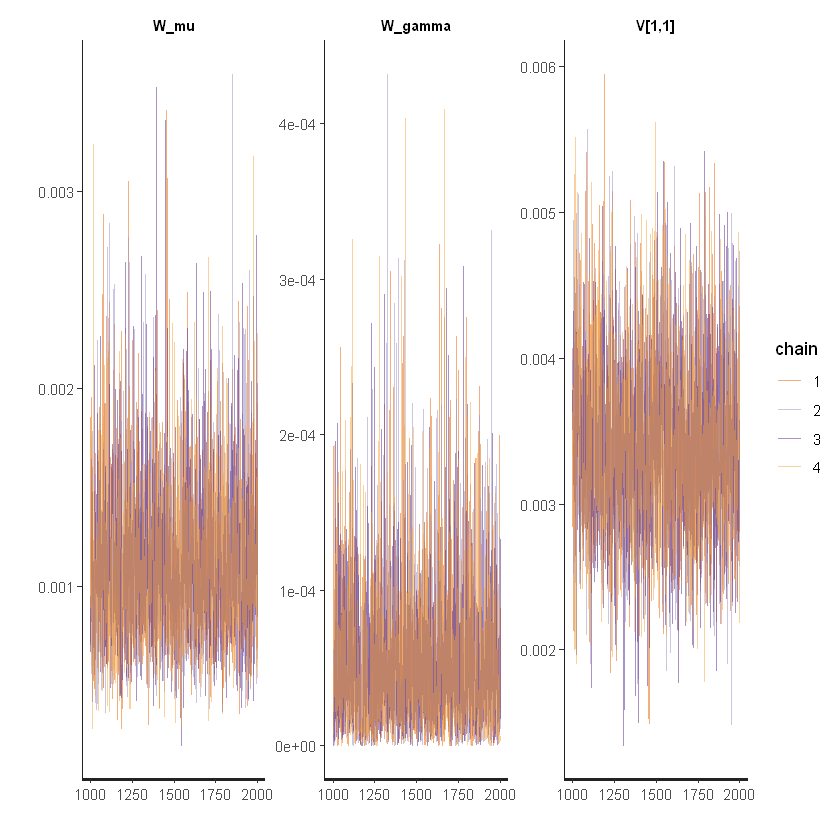

In [13]:
# 結果の確認
fit_stan
traceplot(fit_stan, pars = c("W_mu", "W_gamma", "V"), alpha = 0.5)

- n_eff, Rhatの値が改善
- W_gammaの混ざり具合が改善

In [14]:
# 推定結果の周辺分布の平均を確認
cat(summary(fit_stan)$summary[   "W_mu", "mean"],
    summary(fit_stan)$summary["W_gamma", "mean"],
    summary(fit_stan)$summary[ "V[1,1]", "mean"], "\n")

0.001113789 5.04785e-05 0.003370154 


- 最尤推定値は0.000945628 1.894144e-10 0.003513922 
- 周期成分の状態雑音の分散が大きめになっている
- 最後に、FFBSを用いて状態のサンプルを再生し、パラメータを最尤推定した場合のカルマン平滑化の結果と比較

  |======================================================================| 100%

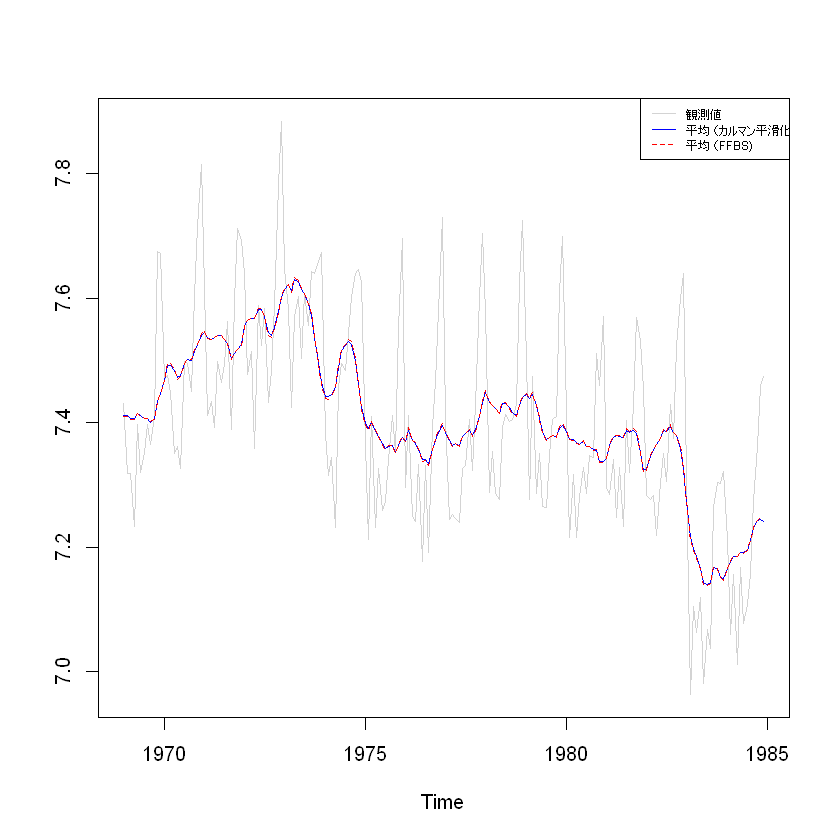

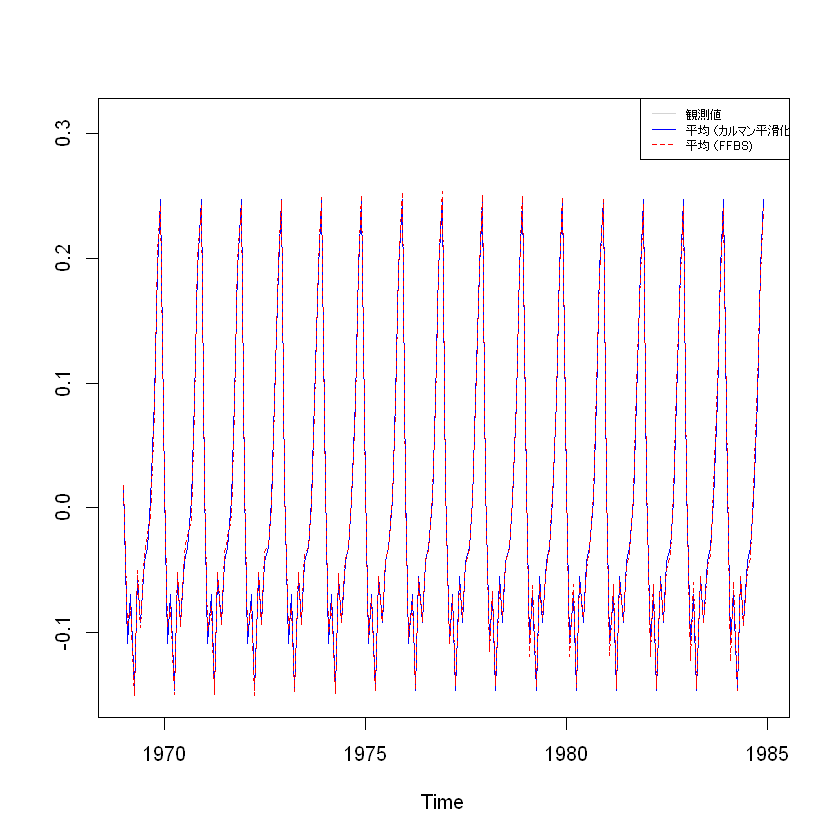

In [15]:
#【英国における自動車運転者死傷者数：FFBSで状態を再生】

# 前処理
set.seed(123)
library(dlm)

# 必要なサンプリング結果を取り出す
stan_mcmc_out <- rstan::extract(fit_stan, pars = c("W_mu", "W_gamma", "V"))

# FFBSの前処理：MCMCの繰り返しステップを設定、進捗バーの設定
it_seq <- seq_along(stan_mcmc_out$V[, 1, 1])
progress_bar <- txtProgressBar(min = 1, max = max(it_seq), style = 3)

# FFBSの本処理：状態の再生
x_FFBS <- lapply(it_seq, function(it){
  # 進捗バーの表示
  setTxtProgressBar(pb = progress_bar, value = it)

  # W, Vの値をモデルに設定
  mod$W[1, 1] <- stan_mcmc_out$W_mu[it]
  mod$W[2, 2] <- stan_mcmc_out$W_gamma[it]
  mod$V[1, 1] <- stan_mcmc_out$V[it, 1, 1]

  # FFBSの実行
  return(dlmBSample(dlmFilter(y = y, mod = mod)))
})

# FFBSの後処理：x0の分を除去して転置（Stanの出力と整合させて、列が時間方向）
   x_mu_FFBS <- t(sapply(x_FFBS, function(x){ x[-1, 1] }))
x_gamma_FFBS <- t(sapply(x_FFBS, function(x){ x[-1, 2] }))

# 周辺化を行い、平均を求める
   mu_FFBS <- colMeans(   x_mu_FFBS)
gamma_FFBS <- colMeans(x_gamma_FFBS)

# 以降のコードは表示を省略

# ts型に変換
   mu_FFBS <- ts(   mu_FFBS); tsp(   mu_FFBS) <- tsp(   mu)
gamma_FFBS <- ts(gamma_FFBS); tsp(gamma_FFBS) <- tsp(gamma)

# 結果のプロット
ts.plot(cbind(y, mu), col = c("lightgray", "blue"))
lines(mu_FFBS, col = "red", lty = "dashed")

# 凡例
legend(legend = c("観測値", "平均 （カルマン平滑化)",  "平均 （FFBS)"),
       lty = c("solid", "solid", "dashed"),
       col = c("lightgray", "blue", "red"),
       x = "topright",  cex = 0.6)

# 結果のプロット
ts.plot(gamma, col = "blue", ylab = "", ylim = c(-0.15, 0.31))
lines(gamma_FFBS, col = "red", lty = "dashed")

# 凡例
legend(legend = c("観測値", "平均 （カルマン平滑化)",  "平均 （FFBS)"),
       lty = c("solid", "solid", "dashed"),
       col = c("lightgray", "blue", "red"),
       x = "topright", cex = 0.6)

- 両者の結果はほぼ一致
- 周期成分の平均に関して少しだけグラフにずれがある
    - 周期成分の状態雑音の分散が最尤推定値に比べて大きめに推定された影響か

### まとめ
- 以上から、複雑なモデルで線形・ガウス型状態空間モデルが部分的に当てはまる場合、カルマンフィルタを部品として利用することで、推定の安定性を改善できることがわかった
    - MCMCで状態とパラメータを同時に推定するよりも、パラメータをMCMCで推定してカルマンフィルタで利用する方が精度が改善できる

1. 確率変数として考えているパラメータのみをMCMCで推定し、その推定結果をカルマンフィルタで利用する
    - MCMCで求める事後分布は$p(\theta|y_{1:T})$
    - ベイズの定理から、$p(\theta|y_{1:T}) \propto p(y_{1:T}|\theta) p(\theta) $
    - $ p(y_{1:T}|\theta)$は線形・ガウス型状態空間モデルの尤度(gaussian_dlm_obs())
    - $p(\theta)$は、事前情報がなければ無情報事前分布
    - こうして得られた$\theta$の推定結果の代表値を点推定値として、カルマンフィルタにプラグイン
1. あくまで同時事後分布$p(x_{0:T}, \theta | y_{1:T})$からのサンプルを求める方法でFFBSを利用
    - ベイズの定理から$p(x_{0:T}, \theta | y_{1:T}) = p(x_{0:T}|\theta, y_{1:T}) p(\theta|y_{1:T})$
    - 1項目の$p(x_{0:T}|\theta, y_{1:T})$は$\theta$が既知という条件になっているため、線形・ガウス型モデルに従い、FFBSが利用できる
    - 2項目の$p(\theta|y_{1:T})$のサンプリングには、上の1.の方法を用いる
    - つまり、計算方法としては、最初に$p(\theta|y_{1:T})$のサンプリングを行い、そのあとFFBSを用いて1項目の$p(x_{0:T}|\theta, y_{1:T})$からサンプリングを行い、状態の標本を再生する
    - FFBSはdlmBSample()
